---
title: 'Efficiently dissolving adjacent polygons by attributes in a large GIS database'
date: 2025-05-15
categories: [GIS, PostGIS]
description: Using PostGIS to efficiently dissolve adjacent polygons by attributes in a large-table with >750k rows of data.
---

Do you have a large GIS dataset where you want to effeciently dissolve all adjacent polygons with the same attribute? In this post, I will share how I achieved that using PostGIS on a landuse dataset with > 750k rows of data.

I will use the Victorian landuse dataset as an example.
This data is freely available from [Data VIC](https://discover.data.vic.gov.au/dataset/victorian-land-use-information-system-2016-2017).
The examples below are shown using the [jupysql](https://jupysql.ploomber.io/en/latest/quick-start.html) extension for JupyterLab.
In this dataset, each parcel of land is assigned an ALUM (*Australian Land Use and Management Classification*) code. Read more about ALUM codes [here](https://www.agriculture.gov.au/abares/aclump/land-use/alum-classification).

# The Motivation
First, let's plot a small sample set of the data using `geopandas` in *Python*, so I can explain my motivation for wanting to dissolve the polygons.

Since the data is saved in a PostGIS table, we'll first create a connection to the database.

In [1]:
import psycopg
from sqlalchemy import create_engine

# database configuration
user = '<username>'
host = 'localhost'
database = '<dbname>'
driver = 'postgresql+psycopg'
connection_str = f'{driver}://{user}@{host}/{database}'

engine = create_engine(connection_str)

I only want to sample subset of the data, so I'll filter only Polygons within 0.025 degrees of a random location (-36.8, 144.1).

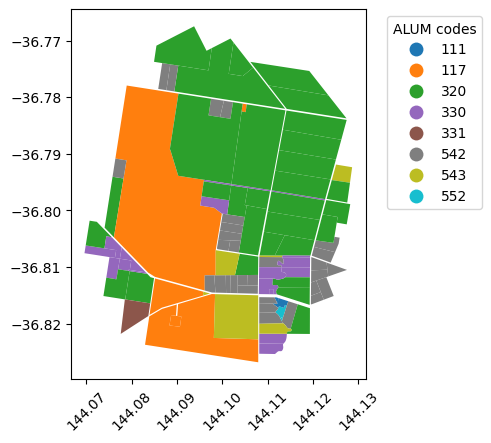

In [2]:
import geopandas as gpd

sql = """
SELECT alumv8, geometry
FROM vic_landuse
WHERE ST_DWithin(geometry,
                    ST_GeomFromText('POINT(144.1 -36.8)', 7844), 0.025)
    AND ST_geometrytype(geometry) = 'ST_Polygon'
"""
sample = gpd.read_postgis(sql, engine, geom_col="geometry")
sample['alumv8'] = sample['alumv8'].astype('category')

ax = sample.plot(
    'alumv8',
    legend=True,
    legend_kwds=dict(loc='upper left', bbox_to_anchor=(1.05, 1), title='ALUM codes')
)
ax.tick_params('x', rotation=45)

In the above map, we have many adjacent land parcels with the same attribute (*alumv8* in this case). I want to create custom tiles based on land use; so I'm not interested in individual parcels of land. For processing purposes, it makes sense for me to reduce the number of geometries by merging adjancent polygons with the same attribute.

# Demonstration using a subset
First, I will demonstrate how I achieved this in a step-by-step manner using the small subset dataframe I created above. Then we can create a script to automate the process for the entire table.

In [3]:
%load_ext sql
    
%sql postgresql+psycopg://<username>@localhost/<dbname

Loading configurations from /home/sandeep/data-science/pyproject.toml.

Settings changed:

Config,value
style,MARKDOWN
feedback,0
displaycon,False


I'll create a new table with the sample data

In [4]:
%%sql
CREATE TABLE
  sample_landuse AS
SELECT
  *
FROM
  vic_landuse
WHERE
  ST_DWithin (
    geometry,
    ST_GeomFromText ('POINT(144.1 -36.8)', 7844),
    0.025
  )
  AND ST_geometrytype (geometry) = 'ST_Polygon'

||
||

In [5]:
%%sql
SELECT
  alumv8,
  COUNT(alumv8)
FROM
  sample_landuse
GROUP BY
  alumv8;

alumv8,count
552,2
330,18
320,30
117,5
543,6
331,1
542,30
111,2


The process I followed is:
1. create a view for each ALUM code.
1. within each code, dissolve geometries if they are adjacent, which results in a separate table.
1. concatenate all tables created in step 2.
1. cleanup any intermediary views and tables.

I will demonstrate each step with an example below.

## Create a view for each ALUM code

This is quite simple. In this case, let's use ALUM code *320*.

In [6]:
%%sql
CREATE VIEW
  landuse_320 AS
SELECT
  *
FROM
  sample_landuse
WHERE
  alumv8 = 320;

||
||

## Dissolve adjacent geometries within each code
The [*ST_ClusterDBSCAN*]() is a window function that returns a cluster number for each input geometry. Geometries that are adjacent to each other are given the same cluster number. 
                                                                             
We'll use *ST_ClusterDBSCAN(geometry, 0, 2)* because we want to cluster geometries within 0 units (degrees) of each other and we want at least two geometries in the cluster.

In [7]:
%%sql
CREATE TABLE
  landuse_320_clustered AS
SELECT
  alumv8,
  ST_ClusterDBSCAN (geometry, 0, 2) OVER () AS cluster_id,
  geometry
FROM
  landuse_320;

||
||

We can see that several clusters have been created with at least 2 polygons.

In [8]:
%%sql
SELECT
  cluster_id,
  COUNT(cluster_id)
FROM
  landuse_320_clustered
GROUP BY
  cluster_id
ORDER BY
  COUNT desc
LIMIT
  5;

cluster_id,count
1,4
0,4
7,4
2,3
4,2


In [9]:
%%sql
CREATE TABLE
  landuse_320_dissolved AS
SELECT
  alumv8,
  ST_Union (geometry) AS geometry
FROM
  landuse_320_clustered
GROUP BY
  alumv8,
  cluster_id;

||
||

Now, we have only 10 polygons instead of the 30 we originally started with.

In [10]:
%%sql
SELECT
  COUNT(*)
FROM
  landuse_320_dissolved;

count
10


## Repeat for all ALUM codes
Now, we can loop through all ALUM codes in the table and repeat the above process for each code.

In [11]:
%%sql
DROP VIEW IF EXISTS landuse_320;
DROP TABLE IF EXISTS landuse_320_clustered;
DROP TABLE IF EXISTS landuse_320_dissolved;

DO $$
DECLARE
    alum_code int;
BEGIN
-- the new table
CREATE TABLE landuse_dissolved (alumv8 int, geometry geometry);

FOR alum_code IN
    SELECT DISTINCT alumv8 FROM sample_landuse
LOOP
    EXECUTE format('DROP VIEW IF EXISTS landuse_%s', alum_code);

    -- create view for the code
    EXECUTE format('
    CREATE VIEW landuse_%s AS
    SELECT * FROM sample_landuse
    WHERE alumv8 = %L',
    alum_code, alum_code);
    
    -- create clustered table
    EXECUTE format(
    	'CREATE TABLE landuse_%s_clustered AS
    	SELECT
    		alumv8,
    		ST_ClusterDBSCAN(geometry, 0, 2) OVER() AS cluster_id,
    		geometry
    	FROM landuse_%s', alum_code, alum_code
    );

    -- dissolve adjacent geometries
    EXECUTE format(
    	'CREATE TABLE landuse_%s_dissolved AS
    	SELECT alumv8, ST_Union(geometry) as geometry
    	FROM landuse_%s_clustered
    	GROUP BY alumv8, cluster_id',
    	alum_code, alum_code
    );

    -- add dissolved geometries to new table
    EXECUTE format('
    	INSERT INTO landuse_dissolved (alumv8, geometry)
    	SELECT alumv8, geometry
    	FROM landuse_%s_dissolved', alum_code
    );

    -- cleanup intermediary views and tables
    EXECUTE format('DROP TABLE landuse_%s_clustered', alum_code);
    EXECUTE format('DROP VIEW landuse_%s', alum_code);
    EXECUTE format('DROP TABLE landuse_%s_dissolved', alum_code);

    COMMIT;
END LOOP;
END $$

||
||

In [12]:
original_rows = %sql SELECT COUNT(*) FROM sample_landuse;
new_rows = %sql SELECT COUNT(*) FROM landuse_dissolved;

print(f"original_rows = {original_rows[0].count}")
print(f"rows after dissolving = {new_rows[0].count}")

original_rows = 94
rows after dissolving = 29


So, after dissolving adjacent polygons, we're down to 29 polygons from the original 94.
Now let's plot the dissolved table `landuse_dissolved` next to the original `sample` table and visually inspect the impact of the abvove process.

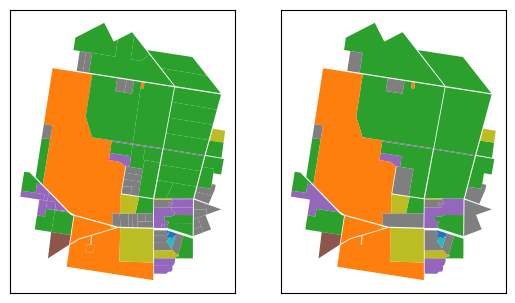

In [13]:
# | classes: preview-image

import matplotlib.pyplot as plt

sql = "SELECT * FROM landuse_dissolved"
sample_dis = gpd.read_postgis(sql, engine, geom_col="geometry")
sample_dis['alumv8'] = sample_dis['alumv8'].astype('category')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sample.plot('alumv8', ax=ax1)
sample_dis.plot('alumv8', ax=ax2)

for ax in [ax1, ax2]:
    ax.set_xticks([])
    ax.set_yticks([])

We can see that no information has been lost, except for individual land parcel boundaries for adjacent geometries with the same ALUM codes. Thus, we can confirm that we have the desired results and can now proceed with doing the same for the entire dataset.

## Area is less?
One thing to note here is that the total area will be less than the original. This is mostly due to the simplification of geometries during the dissolve process, or the elimination of overlapping areas among the polygons.

Let's calculate the total area of each ALUM code and compare the results for both tables.\
*Note*: Since the CRS of the geometry is geographic (EPSG:7844, whose unit is degrees), we'll transform the geometry to the corresponding planar CRS (EPSG:3111, whose unit is in metres) for calculating the area.

In [14]:
%%sql
original_area <<
SELECT
  alumv8,
  SUM(ST_Area (ST_Transform (geometry, 3111))) AS area
FROM
  sample_landuse
GROUP BY
  alumv8;

In [15]:
%%sql
new_area <<
SELECT
  alumv8,
  SUM(ST_Area (ST_Transform (geometry, 3111))) AS area
FROM
  landuse_dissolved
GROUP BY
  alumv8;

We can create a dataframe with the difference in area in sq. metres. Turns out 77 out of 123 ALUM codes have some difference in their total area.

In [18]:
area= original_area.DataFrame().set_index('alumv8').join(new_area.DataFrame().set_index('alumv8'), how='inner', rsuffix='_new')
area['diff'] = area['area'] - area['area_new']
area['diff_pct'] = 100 * (area['area'] - area['area_new']) / area['area']

area

,area,area_new,diff,diff_pct
alumv8,,,,
111,3.552145e+04,3.552145e+04,0.000000e+00,0.000000e+00
117,7.232697e+06,7.232697e+06,9.313226e-10,1.287656e-14
320,1.201683e+07,1.201683e+07,3.725290e-09,3.100060e-14
330,1.191974e+06,1.191974e+06,6.984919e-10,5.859962e-14
331,2.330225e+05,2.330225e+05,0.000000e+00,0.000000e+00
542,1.928476e+06,1.928476e+06,-1.164153e-09,-6.036648e-14
543,1.174942e+06,1.174942e+06,0.000000e+00,0.000000e+00
552,3.209726e+04,3.209726e+04,-7.275958e-12,-2.266847e-14


We can see that the area is different for 5/8 ALUM codes. While the difference is miniuscle for this sample dataset, the differences can add up when we have a large dataset.

Therefore, it is important to keep this in mind when deciding whether this kind of dissolving is appropriate for the task at hand.

# Dissolving adjacent polygons in the entire dataset
Dissolving all adjacent polygons with the same ALUM8 code for the entire dataset of >750k rows is, of course, an expensive and time consuming process. A short coffee break, or some stretching perhaps?
 
But the results are quite impressive. I ended up with only ~ 112k rows, a reduction of 85\%.

In [26]:
original_rows = %sql SELECT COUNT(*) FROM vic_landuse;
new_rows = %sql SELECT COUNT(*) FROM vic_landuse_dissolved;

print(f"original_rows = {original_rows[0].count}")
print(f"rows after dissolving = {new_rows[0].count}")

original_rows = 751295
rows after dissolving = 112603


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

We can immediately see the difference in certain tasks such as plotting with the reduced number of rows. Plotting the original dataset with *geopandas* takes ~2 minutes on my computer, whereas only ~50s is needed for the dissolved dataset.

In [ ]:
sql = "SELECT * FROM vic_landuse"
vic_landuse = gpd.read_postgis(sql, engine, geom_col="geometry")
vic_landuse["alumv8"] = vic_landuse["alumv8"].astype("category")

CPU times: user 1min 58s, sys: 1.8 s, total: 2min
Wall time: 2min


<Axes: >

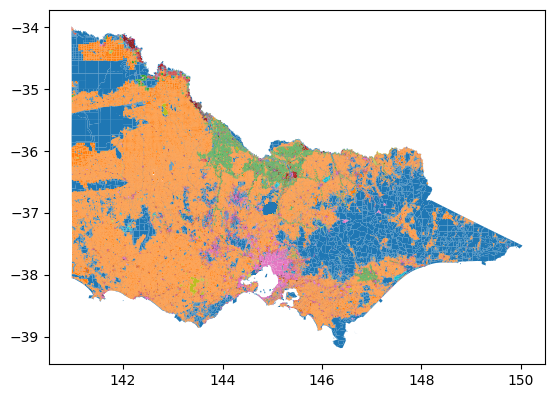

In [8]:
%time vic_landuse.plot('alumv8')

CPU times: user 50.2 s, sys: 62.9 ms, total: 50.2 s
Wall time: 50.2 s


<Axes: >

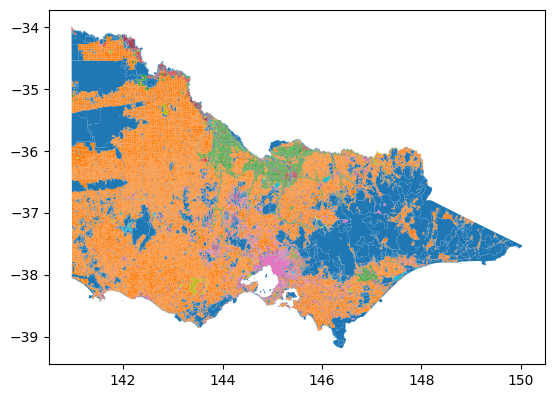

In [17]:
sql = "SELECT * FROM vic_landuse_dissolved"
vic_dis = gpd.read_postgis(sql, engine, geom_col="geometry")
vic_dis["alumv8"] = vic_dis["alumv8"].astype("category")

%time vic_dis.plot('alumv8')